In [2]:
# Packages
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt

from utility_code.utility import utils

In [3]:
#import csvs
train_import = pd.read_csv("ucla2020-cs145-covid19-prediction/train.csv")
test_import = pd.read_csv("ucla2020-cs145-covid19-prediction/test.csv")
graph = pd.read_csv("ucla2020-cs145-covid19-prediction/graph.csv")

In [4]:
#only look at the features in features list
features = ['Confirmed','Deaths', 'Incident_Rate', 'Mortality_Rate']
num_features = len(features)

In [5]:
#array of states
states = pd.Series.unique(train_import['Province_State'])
num_states = len(states)

In [6]:
#split training into training and testing
PERCENT_TRAIN = 80
train , test = utils.split_dataframe(train_import,PERCENT_TRAIN,num_states)

In [7]:
#stratify by state (into state dictionary)
statesdata = {}
for s in states:
    statesdata[s] = train.loc[train['Province_State'] == s ,features]
    
#feature name -> column indices
state_feature_indices = utils.get_column_indices(statesdata['California'],features)

In [8]:
#set the WINDOW size
WINDOW_SIZE = 3

In [9]:
#append the feature spaces from the W days prior (where W is the window length)
new_features = []
for day in range(WINDOW_SIZE):
    for f in features:
        new_features.append(f + "(-"+ str(WINDOW_SIZE-day) + " days)")
all_new_features = new_features + features

In [10]:
from itertools import chain

#fill the knn data using days from training set
knndata = pd.DataFrame(columns = all_new_features)
num_training_days = len(statesdata['California'])

#fill the table
for d in range(WINDOW_SIZE,num_training_days):
    for s in states:
        knndata_row_index = knndata.shape[0]
        knn_row = utils.flatten_dataframe(statesdata[s],slice(d-WINDOW_SIZE,d+1), state_feature_indices)
        utils.dataframe_append_row(knndata,knn_row,s,d)     

In [11]:
#number of nearest neighbors
K_NEIGHBORS = 2

#number of days to predict in the future (for now let's predict for entirety of test labels)
NUM_DAYS_INTO_FUTURE = int(test.shape[0] / num_states)

In [15]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors = K_NEIGHBORS)

#get rid of previously predicted rows
knndata = knndata.iloc[:(num_training_days - WINDOW_SIZE)*num_states,:]

#feature name -> column indices
knn_feature_indices = utils.get_column_indices(knndata,features)

#build table for next NUM_DAYS_INTO_FUTURE entries
for d in range(num_training_days,num_training_days + NUM_DAYS_INTO_FUTURE):
    
    #refit the model after every day
    knn.fit(knndata.iloc[:,:-1 * num_features])
    
    for s in states:
        #get rows for past WINDOW_SIZE days
        row_indicies = slice(knndata.shape[0] - num_states * WINDOW_SIZE, knndata.shape[0], num_states)
        knn_row_features = utils.flatten_dataframe(knndata,row_indicies,slice(-1 * num_features,None,None))
        #if d == num_training_days:
            #print(knn_row_features)
        #find nearest neighbors based on these features
        knn_ret = knn.kneighbors([knn_row_features])[1][0]
        #if d == num_training_days:
            #print(knn_ret)
        knn_ret_df = knndata.iloc[knn_ret,-1 * num_features:]
        #if d == num_training_days:
            #print(knn_ret_df)
        #interpolate btwn the labels in the df
        for f in features:
            knn_row_features += [int(knn_ret_df[f].mean())]
            
        if d== num_training_days:
            print(knn_row_features)
        utils.dataframe_append_row(knndata,knn_row_features,s,d)     

[87723.0, 1580.0, 1789.1023895692292, 1.8011239925675135, 89349.0, 1603.0, 1822.2645076618564, 1.7940883501773943, 91444.0, 1627.0, 1864.9918369386428, 1.7792310047679454, 92862, 1372, 1579, 1]
[2990.0, 23.0, 408.72400194109724, 0.7692307692307693, 3136.0, 24.0, 428.681762570997, 0.7653061224489796, 3280.0, 24.0, 448.3661292196652, 0.7317073170731707, 3355, 54, 448, 1]
[174010.0, 3694.0, 2390.6685752447856, 2.1228665019251767, 177002.0, 3747.0, 2431.774720737185, 2.116925232483249, 178467.0, 3765.0, 2451.9018942486705, 2.1096337137958283, 184319, 3711, 1736, 2]
[42511.0, 453.0, 1408.6733266971612, 1.0656065488932276, 43173.0, 458.0, 1430.609807661465, 1.06084821531976, 43810.0, 464.0, 1451.7178716709234, 1.0591189226204063, 44610, 812, 1431, 1]
[500556.0, 9214.0, 1266.8383654344125, 1.84075308257218, 506613.0, 9345.0, 1282.1677990630901, 1.8446032770576362, 512175.0, 9396.0, 1296.2444557978931, 1.8345292136476792, 509394, 9370, 1289, 1]
[46791.0, 1838.0, 812.5220534506184, 3.9281058323

/Users/Aditya/Desktop/FALL20/CS145/COVID19_prediction/utility_code/utility.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[row_name,:] = row


In [12]:
#analyze labels vs predictions
pd.set_option("display.max_rows", None, "display.max_columns", None)
knn_predictions = knndata.iloc[(num_training_days - WINDOW_SIZE)*num_states:,-1 * num_features:]
knn_labels = utils.dataframe_copy_rows_and_filter_columns(test,knn_predictions)
knn_errors = knn_predictions.subtract(knn_labels)

In [13]:
print('average errors: ', knn_errors.divide(knn_labels).abs().mean(axis = 0))

average errors:  Confirmed         0.122174
Deaths            0.328855
Incident_Rate     0.243944
Mortality_Rate    0.336071
dtype: float64


<function matplotlib.pyplot.show>

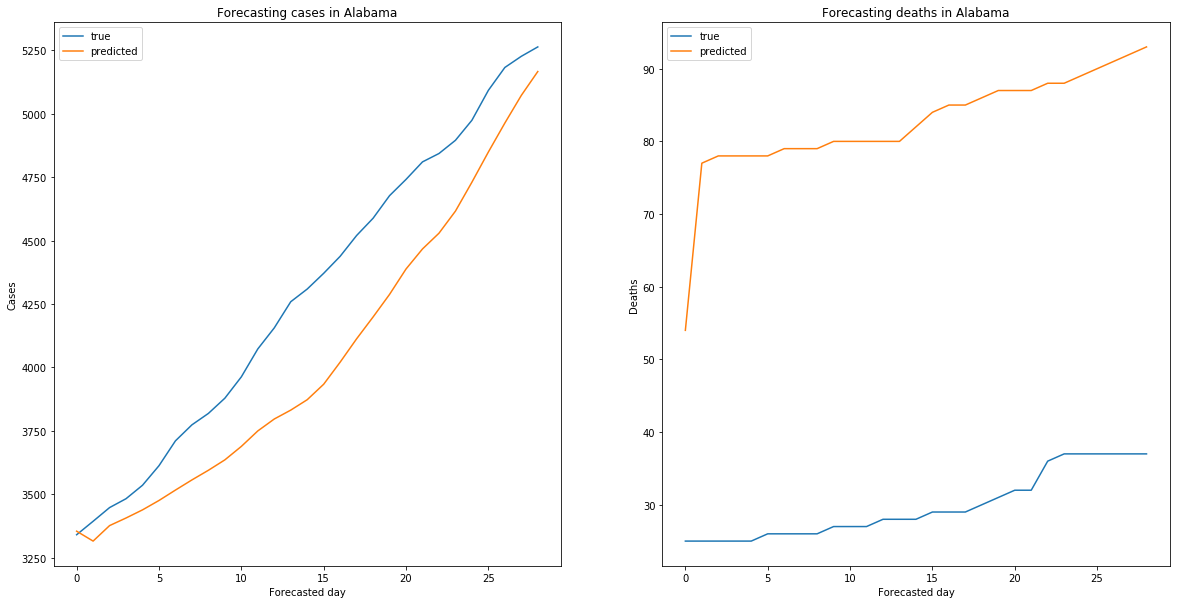

In [46]:
days = list(range(NUM_DAYS_INTO_FUTURE))
ala_inds = [1 + 50*i for i in range(NUM_DAYS_INTO_FUTURE)]
alabama_true = knn_labels.iloc[ala_inds]
alabama_pred = knn_predictions.iloc[ala_inds]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.plot(days, alabama_true['Confirmed'])
ax1.plot(days, alabama_pred['Confirmed'])
ax2.plot(days, alabama_true['Deaths'])
ax2.plot(days, alabama_pred['Deaths'])
ax2.legend(['true', 'predicted'])
ax1.legend(['true', 'predicted'])
ax1.set_xlabel('Forecasted day')
ax1.set_ylabel('Cases')
ax2.set_xlabel('Forecasted day')
ax2.set_ylabel('Deaths')
ax1.set_title('Forecasting cases in Alabama')
ax2.set_title('Forecasting deaths in Alabama')
f.set_figheight(10)
f.set_figwidth(20)
plt.savefig("MidtermReportFigs/ala_forecasts.png")
plt.show

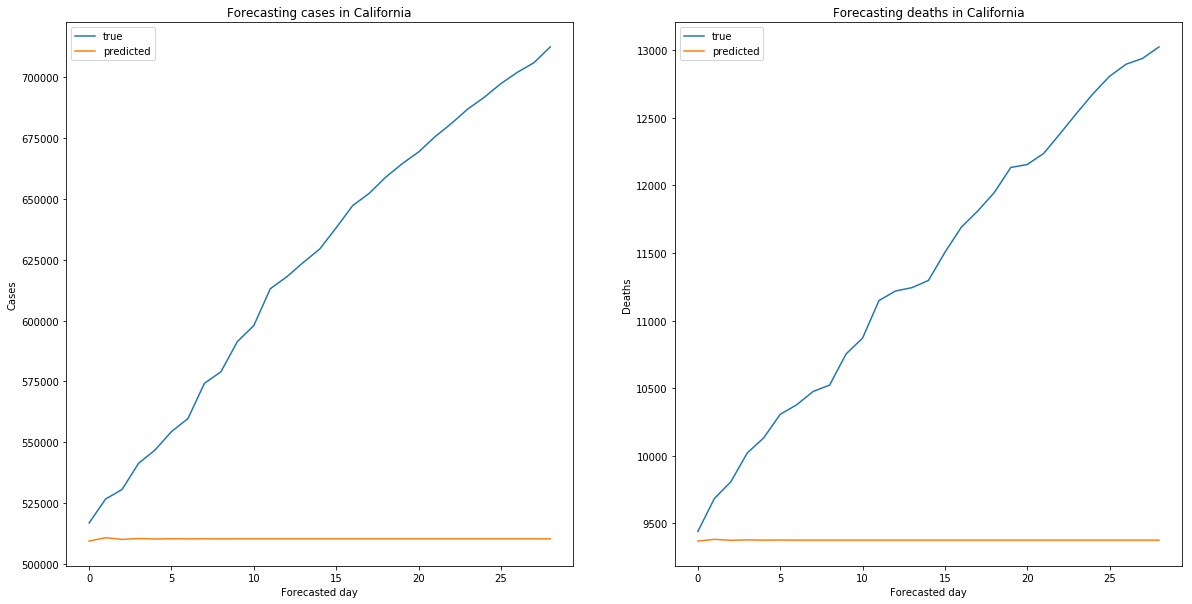

In [45]:
days = list(range(NUM_DAYS_INTO_FUTURE))
calif_inds = [4 + 50*i for i in range(NUM_DAYS_INTO_FUTURE)]
calif_true = knn_labels.iloc[calif_inds]
calif_pred = knn_predictions.iloc[calif_inds]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.plot(days, calif_true['Confirmed'])
ax1.plot(days, calif_pred['Confirmed'])
ax2.plot(days, calif_true['Deaths'])
ax2.plot(days, calif_pred['Deaths'])
ax2.legend(['true', 'predicted'])
ax1.legend(['true', 'predicted'])
ax1.set_xlabel('Forecasted day')
ax1.set_ylabel('Cases')
ax2.set_xlabel('Forecasted day')
ax2.set_ylabel('Deaths')
ax1.set_title('Forecasting cases in California')
ax2.set_title('Forecasting deaths in California')
f.set_figheight(10)
f.set_figwidth(20)
plt.show
plt.savefig("MidtermReportFigs/calif_forecasts.png")

In [40]:
knn_true

,Confirmed,Deaths,Incident_Rate,Mortality_Rate
Alabama (day 113),92661,1633,1889.812438,1.762338
Alaska (day 113),3341,25,456.704646,0.748279
Arizona (day 113),179497,3779,2466.052740,2.105328
Arkansas (day 113),44597,475,1477.796437,1.065094
California (day 113),516851,9441,1308.078768,1.826639
Colorado (day 113),47950,1844,832.647998,3.845673
Connecticut (day 113),50062,4437,1404.150634,8.863010
Delaware (day 113),15055,585,1546.062496,3.885752
Florida (day 113),491884,7157,2290.204038,1.455018
Georgia (day 113),195435,3842,1840.700893,1.965871
